In [1]:
from __future__ import absolute_import, division, print_function
import torch
from torch.distributions import constraints
from torch.nn import Parameter
import pyro
from pyro.contrib.gp.util import Parameterized
import pyro.distributions as dist
import pyro.infer as infer
import pyro.optim as optim
from pyro.params import param_with_module_name
import pyro.contrib.gp as gp
import pyro.distributions as dist
import matplotlib.pyplot as plt
pyro.clear_param_store()
import tensorflow as tf
import numpy as np 
import pandas as pd
import numpy
import math
import cProfile
import time
torch.manual_seed(101)
pyro.set_rng_seed(1)
import GPy
import numpy as np
from matplotlib import pyplot as plt

import statsmodels.api as sm
import sympy as sp
#import pymc
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats
from scipy.special import gamma
from GPy.core.parameterization.variational import NormalPosterior, NormalPrior

from sympy.interactive import printing
import pyro.contrib.gp.models.vsgp as vsgp
from GPy.util.linalg import pdinv

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
# Load the Dataset
y = torch.stack([dist.Normal(4.8, 0.1).sample((150,)),dist.Normal(3.2, 0.3).sample((150,)),dist.Normal(1.5, 0.4).sample((150,)),
 dist.Exponential(0.5).sample((150,))])
# Fixed Inducing Inputs for Sparse Model
X_loc = torch.zeros(150, 2)
# Kenel
kernel = gp.kernels.RBF(input_dim=2,lengthscale=torch.ones(1),variance=torch.ones(1))
Xu = torch.zeros(20, 2)
# Wrap Sparse GP Model below into GPLVM
likelihood = gp.likelihoods.Gaussian()
#vsgp = gp.models.VariationalSparseGP(X_loc, y, kernel, Xu, likelihood)
gpmodel = gp.models.SparseGPRegression(X_loc, y, kernel, Xu, noise=torch.tensor(1.))
#gplvm = gp.models.GPLVM(vsgp)
gplvm = gp.models.GPLVM(gpmodel)
# Optimize Bayesian GPLVM
losses = gplvm.optimize(num_steps=2000)

In [3]:
X = gplvm.get_param("X_loc")
X_var = gplvm.get_param("X_scale_tril")

In [4]:
Kfu = gplvm.base_model.kernel(X, gplvm.base_model.Xu).detach().numpy()
Kuu = gplvm.base_model.kernel(gplvm.base_model.Xu, gplvm.base_model.Xu).detach().numpy()
Kuf = Kfu.T
print('Kfu shape'+str(Kfu.shape))
print('Kuu shape'+str(Kuu.shape))
print('Kuf shape'+str(Kuf.shape))

Kfu shape(150, 20)
Kuu shape(20, 20)
Kuf shape(20, 150)


In [5]:
noise = gplvm.base_model.get_param('noise').detach().numpy()
K = np.dot(np.dot(Kfu,pdinv(Kuu)[0]),Kuf)  + np.eye(X.shape[0])*(1/noise)

In [9]:
Y = numpy.array(y)
Y = Y.T # Reshaping vector 150 x 4 for Bayesian GPLVM
kernel = GPy.kern.RBF(2, ARD=True,variance=1.0,lengthscale=1.0)
m = GPy.models.BayesianGPLVM(Y, 2,  init="PCA",kernel=kernel,num_inducing=20)
#m.Gaussian_noise=noise
m.data_labels = Y.argmax(axis=1)
loss = m.optimize('scg', messages=1,max_iters=5000)

Running Scaled Conjugate Gradients Code:
  runtime   i      f              |g|        
    00s15  0008   1.789270e+03   1.531403e+04 
    00s19  0011   1.185150e+03   1.514494e+05 
    02s20  0229   5.087667e+02   4.988197e+02 
    07s24  0753   4.836468e+02   2.884587e+01 

 /home/aneeqr/.local/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /home/aneeqr/.local/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:invalid value encountered in add


    08s25  0858   4.807278e+02   3.051784e+01 
    25s32  2610   4.559232e+02   2.481964e+01 
    55s45  5647   4.448573e+02   2.001089e+01 

 /home/aneeqr/.local/lib/python3.6/site-packages/GPy/kern/src/stationary.py:136: RuntimeWarning:overflow encountered in square


 01m02s13  6314   4.389018e+02   1.822089e+01 
Runtime:  01m02s13
Optimization status: converged - relative stepsize



In [10]:
Kfu2 =  m.kern.K(m.X.mean, m.Z)
Kuu2 = m.kern.K(m.Z, m.Z)
Kuf2 = Kfu.T 
print('Kfu shape'+str(Kfu2.shape))
print('Kuu shape'+str(Kuu2.shape))
print('Kuf shape'+str(Kuf2.shape))

Kfu shape(150, 20)
Kuu shape(20, 20)
Kuf shape(20, 150)


In [11]:
Kff = np.dot(np.dot(Kfu2,pdinv(Kuu2)[0]),Kuf2)
Kff = Kff + np.eye(m.X.mean.shape[0])*(1/m.Gaussian_noise.variance)

Text(0.5,1.05,'Full Covariance')

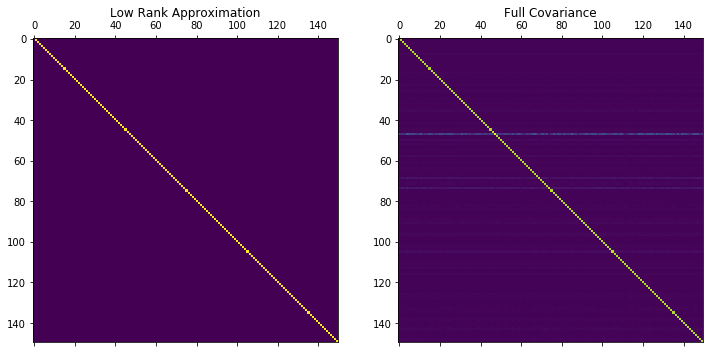

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(12, 8))
ax[0].matshow(K)
ax[0].set_title('Low Rank Approximation')
ax[1].matshow(Kff)
ax[1].set_title('Full Covariance')

In [16]:
Samples=500
VS = [] # Vector Containing Matrix Samples (Xs)
for i in range(Samples):
    VS.append(pyro.sample('Variational Distibtuion',dist.MultivariateNormal(gplvm.get_param("X_loc"), scale_tril=gplvm.get_param("X_scale_tril")).independent(gplvm.get_param("X_loc").dim()-1),))


In [20]:
def Joint_Prob(Y,Xs,N,D,Q,m,K_new):
    K_inv = np.linalg.inv(K_new)
    Prob = -N*D*0.5*np.log(2*np.pi) - D/2*np.log(np.linalg.det(K_new))-1/2*np.trace(np.matmul(np.matmul(Y.T,K_inv),Y)) - (N*Q/2)*np.log(2*np.pi)-0.5*np.trace(np.matmul(Xs,Xs.T))
    return Prob 

In [18]:
N= y.shape[0]
Q = 2
D=4
Join = []
for sample in VS:
    Join.append(Joint_Prob(Y,sample.detach().numpy(),N,D,Q,m,Kff))

In [25]:
def Var(X,gplvm,D,K_new):
    K_inv = np.linalg.inv(K_new)
    #K_inv = pdinv(K_new)[0]
    temp = np.matmul(np.matmul(X.detach().numpy().T,K_inv),X.detach().numpy()) 
    qx = -0.5*(K.shape[0]*(D))*(np.log(np.pi*2)) - D/2*np.log(np.linalg.det(K_new)) - 0.5*np.trace(temp)
    return qx

In [26]:
qx = []
for sample in VS:
    qx.append(Var(sample,gplvm=gplvm,D=2,K_new=K))

In [28]:
def log_Ratios(qx,Join):
    Rs = [] # Rations with exp
    Rs2 = [] # Rations without exp just log ratios
    for i in range(len(qx)):
        Rs.append(np.exp(Join[i]-qx[i]))
        Rs2.append(Join[i]-qx[i])
    return Rs,Rs2

In [29]:
Rs,Rs2 = log_Ratios(qx,Join)

In [32]:
print('K:'+ str(psisloo(np.array(Rs2)))) 

K:(-694.2929797327164, -694.2929797327164, 0.5518015128544602)


$$
D_\text{KL}(\mathcal{N}_0 \| \mathcal{N}_1) = { 1 \over 2 } \left( \mathrm{tr} \left( \Sigma_1^{-1} \Sigma_0 \right) + \left( \mu_1 - \mu_0\right)^\text{T} \Sigma_1^{-1} ( \mu_1 - \mu_0 ) - k + \ln \left( { \det \Sigma_1 \over \det \Sigma_0  } \right)  \right)
$$

In [75]:
def KL_divergence(K1,K0,u1,u0):
    # K0,u0-POS
    # DKL(P||Q)
    temp=u1-u0
    div1 =  0.5*(np.trace(np.matmul(np.linalg.inv(K1),K0)) + np.dot(np.dot(temp.T,pdinv(K1)[0]),temp) -  K.ndim + np.log(np.linalg.det(K1)/np.linalg.det(K0)))
    # DKL(Q||P)
    temp=u0-u1
    div2 =  0.5*(np.trace(np.matmul(np.linalg.inv(K0),K1)) + np.dot(np.dot(temp.T,np.linalg.inv(K0)),temp) -  K.ndim + np.log(np.linalg.det(K0)/np.linalg.det(K1)))
    print(div1)
    print(div2)
    return 0

In [76]:
 KL_divergence(K,Kff,X_loc.detach().numpy(),m.X.mean)

[[1265.59877314 1218.36998299]
 [1218.36998299 1307.23172468]]
[[226.44842013 223.71075067]
 [223.83874764 229.09608958]]


0

In [81]:
def model(y):
        X_loc = torch.zeros(y.shape[1], 2)
        kernel = gp.kernels.RBF(input_dim=2, lengthscale=torch.ones(2))
        Xu = torch.zeros(20, 2)  # initial inducing inputs of sparse model
        gpmodel = gp.models.SparseGPRegression(X_loc, y, kernel, Xu, noise=torch.tensor(1.))
        X_loc = gpmodel.X
        C = X_loc.shape[1]
        Id = torch.eye(C, out=X_loc.new_empty(C, C))
        zero_loc = X_loc.new_zeros(X_loc.shape)
        X = pyro.sample('Var_dist', dist.MultivariateNormal(zero_loc, scale_tril=Id)
                                    .independent(zero_loc.dim()-1))
        return X

In [84]:
from pyro.infer.mcmc.hmc import HMC
from pyro.infer.mcmc import MCMC

In [85]:
hmc_kernel = HMC(model, step_size=0.0855, num_steps=4,adapt_step_size=True)
mcmc_run = MCMC(hmc_kernel, num_samples=500, warmup_steps=100).run(y)

In [86]:
posterior = pyro.infer.abstract_infer.EmpiricalMarginal(mcmc_run)

In [87]:
Samples = posterior.sample_n(500)

 /home/aneeqr/.local/lib/python3.6/site-packages/torch/distributions/distribution.py:112: UserWarning:sample_n will be deprecated. Use .sample((n,)) instead


In [88]:
trace_log_pdf = []
for tr in mcmc_run.exec_traces:
    trace_log_pdf.append(tr.log_prob_sum())

In [91]:
N= y.shape[0]
Q = 2
D=4
Join = []
for sample in Samples:
    Join.append(Joint_Prob(Y,sample.detach().numpy(),N,D,Q,m,Kff))

In [94]:
VS2= list(np.array(trace_log_pdf).flatten())

In [101]:
Rs,Rs2 = log_Ratios(VS2,Join)

In [99]:
print('K:'+ str(psisloo(np.array(Rs2)))) 

K:(-744.7014876668032, -744.7014876668032, 4.986162081014061)


In [31]:
def psisloo(log_lik, **kwargs):
    r"""PSIS leave-one-out log predictive densities.

    Computes the log predictive densities given posterior samples of the log
    likelihood terms :math:`p(y_i|\theta^s)` in input parameter `log_lik`.
    Returns a sum of the leave-one-out log predictive densities `loo`,
    individual leave-one-out log predictive density terms `loos` and an estimate
    of Pareto tail indeces `ks`. The estimates are unreliable if tail index
    ``k > 0.7`` (see more in the references listed in the module docstring).

    Additional keyword arguments are passed to the :meth:`psislw()` function
    (see the corresponding documentation).

    Parameters
    ----------
    log_lik : ndarray
        Array of size n x m containing n posterior samples of the log likelihood
        terms :math:`p(y_i|\theta^s)`.

    Returns
    -------
    loo : scalar
        sum of the leave-one-out log predictive densities

    loos : ndarray
        individual leave-one-out log predictive density terms

    ks : ndarray
        estimated Pareto tail indeces

    """
    # ensure overwrite flag in passed arguments
    kwargs['overwrite_lw'] = True
    # log raw weights from log_lik
    lw = -log_lik
    # compute Pareto smoothed log weights given raw log weights
    lw, ks = psislw(lw, **kwargs)
    # compute
    lw += log_lik
    loos = sumlogs(lw, axis=0)
    loo = loos.sum()
    #print('Ks'+str(ks))
    return loo, loos, ks

def psislw(lw, Reff=1.0, overwrite_lw=False):
    """Pareto smoothed importance sampling (PSIS).

    Parameters
    ----------
    lw : ndarray
        Array of size n x m containing m sets of n log weights. It is also
        possible to provide one dimensional array of length n.

    Reff : scalar, optional
        relative MCMC efficiency ``N_eff / N``

    overwrite_lw : bool, optional
        If True, the input array `lw` is smoothed in-place, assuming the array
        is F-contiguous. By default, a new array is allocated.

    Returns
    -------
    lw_out : ndarray
        smoothed log weights
    kss : ndarray
        Pareto tail indices

    """
    if lw.ndim == 2:
        n, m = lw.shape
    elif lw.ndim == 1:
        n = len(lw)
        m = 1
    else:
        raise ValueError("Argument `lw` must be 1 or 2 dimensional.")
    if n <= 1:
        raise ValueError("More than one log-weight needed.")

    if overwrite_lw and lw.flags.f_contiguous:
        # in-place operation
        lw_out = lw
    else:
        # allocate new array for output
        lw_out = np.copy(lw, order='F')

    # allocate output array for kss
    kss = np.empty(m)
    #print(kss)

    # precalculate constants
    cutoff_ind = - int(np.ceil(min(0.2 * n, 3 * np.sqrt(n / Reff)))) - 1
    cutoffmin = np.log(np.finfo(float).tiny)
    logn = np.log(n)
    k_min = 1/3

    # loop over sets of log weights
    for i, x in enumerate(lw_out.T if lw_out.ndim == 2 else lw_out[None, :]):
        # improve numerical accuracy
        x -= np.max(x)
        # sort the array
        x_sort_ind = np.argsort(x)
        # divide log weights into body and right tail
        xcutoff = max(
            x[x_sort_ind[cutoff_ind]],
            cutoffmin
        )
        expxcutoff = np.exp(xcutoff)
        tailinds, = np.where(x > xcutoff)
        x2 = x[tailinds]
        n2 = len(x2)
        if n2 <= 4:
            # not enough tail samples for gpdfitnew
            k = np.inf
        else:
            # order of tail samples
            x2si = np.argsort(x2)
            # fit generalized Pareto distribution to the right tail samples
            np.exp(x2, out=x2)
            x2 -= expxcutoff
            k, sigma = gpdfitnew(x2, sort=x2si)
        if k >= k_min and not np.isinf(k):
            # no smoothing if short tail or GPD fit failed
            # compute ordered statistic for the fit
            sti = np.arange(0.5, n2)
            sti /= n2
            qq = gpinv(sti, k, sigma)
            qq += expxcutoff
            np.log(qq, out=qq)
            # place the smoothed tail into the output array
            x[tailinds[x2si]] = qq
            # truncate smoothed values to the largest raw weight 0
            x[x > 0] = 0
        # renormalize weights
        x -= sumlogs(x)
        # store tail index k
        kss[i] = k
        #print(k)

    # If the provided input array is one dimensional, return kss as scalar.
    if lw_out.ndim == 1:
        kss = kss[0]

    return lw_out, kss

def sumlogs(x, axis=None, out=None):
    """Sum of vector where numbers are represented by their logarithms.

    Calculates ``np.log(np.sum(np.exp(x), axis=axis))`` in such a fashion that
    it works even when elements have large magnitude.

    """
    maxx = x.max(axis=axis, keepdims=True)
    xnorm = x - maxx
    np.exp(xnorm, out=xnorm)
    out = np.sum(xnorm, axis=axis, out=out)
    if isinstance(out, np.ndarray):
        np.log(out, out=out)
    else:
        out = np.log(out)
    out += np.squeeze(maxx)
    return out
def gpdfitnew(x, sort=True, sort_in_place=False, return_quadrature=False):
    """Estimate the paramaters for the Generalized Pareto Distribution (GPD)

    Returns empirical Bayes estimate for the parameters of the two-parameter
    generalized Parato distribution given the data.

    Parameters
    ----------
    x : ndarray
        One dimensional data array

    sort : bool or ndarray, optional
        If known in advance, one can provide an array of indices that would
        sort the input array `x`. If the input array is already sorted, provide
        False. If True (default behaviour), the array is sorted internally.

    sort_in_place : bool, optional
        If `sort` is True and `sort_in_place` is True, the array is sorted
        in-place (False by default).

    return_quadrature : bool, optional
        If True, quadrature points and weight `ks` and `w` of the marginal posterior distribution of k are also calculated and returned. False by
        default.

    Returns
    -------
    k, sigma : float
        estimated parameter values

    ks, w : ndarray
        Quadrature points and weights of the marginal posterior distribution
        of `k`. Returned only if `return_quadrature` is True.

    Notes
    -----
    This function returns a negative of Zhang and Stephens's k, because it is
    more common parameterisation.

    """
    if x.ndim != 1 or len(x) <= 1:
        raise ValueError("Invalid input array.")

    # check if x should be sorted
    if sort is True:
        if sort_in_place:
            x.sort()
            xsorted = True
        else:
            sort = np.argsort(x)
            xsorted = False
    elif sort is False:
        xsorted = True
    else:
        xsorted = False

    n = len(x)
    PRIOR = 3
    m = 30 + int(np.sqrt(n))

    bs = np.arange(1, m + 1, dtype=float)
    bs -= 0.5
    np.divide(m, bs, out=bs)
    np.sqrt(bs, out=bs)
    np.subtract(1, bs, out=bs)
    if xsorted:
        bs /= PRIOR * x[int(n/4 + 0.5) - 1]
        bs += 1 / x[-1]
    else:
        bs /= PRIOR * x[sort[int(n/4 + 0.5) - 1]]
        bs += 1 / x[sort[-1]]

    ks = np.negative(bs)
    temp = ks[:,None] * x
    np.log1p(temp, out=temp)
    np.mean(temp, axis=1, out=ks)

    L = bs / ks
    np.negative(L, out=L)
    np.log(L, out=L)
    L -= ks
    L -= 1
    L *= n

    temp = L - L[:,None]
    np.exp(temp, out=temp)
    w = np.sum(temp, axis=1)
    np.divide(1, w, out=w)

    # remove negligible weights
    dii = w >= 10 * np.finfo(float).eps
    if not np.all(dii):
        w = w[dii]
        bs = bs[dii]
    # normalise w
    w /= w.sum()

    # posterior mean for b
    b = np.sum(bs * w)
    # Estimate for k, note that we return a negative of Zhang and
    # Stephens's k, because it is more common parameterisation.
    temp = (-b) * x
    np.log1p(temp, out=temp)
    k = np.mean(temp)
    if return_quadrature:
        np.negative(x, out=temp)
        temp = bs[:, None] * temp
        np.log1p(temp, out=temp)
        ks = np.mean(temp, axis=1)
    # estimate for sigma
    sigma = -k / b * n / (n - 0)
    # weakly informative prior for k
    a = 10
    k = k * n / (n+a) + a * 0.5 / (n+a)
    if return_quadrature:
        ks *= n / (n+a)
        ks += a * 0.5 / (n+a)

    if return_quadrature:
        #print('K:'+str(k))
        return k, sigma, ks, w
    else:
        #print('K:'+str(k))
        return k, sigma

def gpinv(p, k, sigma):
    """Inverse Generalised Pareto distribution function."""
    x = np.empty(p.shape)
    x.fill(np.nan)
    if sigma <= 0:
        return x
    ok = (p > 0) & (p < 1)
    if np.all(ok):
        if np.abs(k) < np.finfo(float).eps:
            np.negative(p, out=x)
            np.log1p(x, out=x)
            np.negative(x, out=x)
        else:
            np.negative(p, out=x)
            np.log1p(x, out=x)
            x *= -k
            np.expm1(x, out=x)
            x /= k
        x *= sigma
    else:
        if np.abs(k) < np.finfo(float).eps:
            # x[ok] = - np.log1p(-p[ok])
            temp = p[ok]
            np.negative(temp, out=temp)
            np.log1p(temp, out=temp)
            np.negative(temp, out=temp)
            x[ok] = temp
        else:
            # x[ok] = np.expm1(-k * np.log1p(-p[ok])) / k
            temp = p[ok]
            np.negative(temp, out=temp)
            np.log1p(temp, out=temp)
            temp *= -k
            np.expm1(temp, out=temp)
            temp /= k
            x[ok] = temp
        x *= sigma
        x[p == 0] = 0
        if k >= 0:
            x[p == 1] = np.inf
        else:
            x[p == 1] = -sigma / k
    return x